In [1]:
import pandas as pd
from pathlib import Path
import random
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tifffile as tiff
import cv2

data_path = Path('/kaggle/input/')
TRAIN_PATH= str(data_path) + "/hubmap-organ-segmentation/train_images/"


In [2]:
train_df = pd.read_csv(data_path/ 'hubmap-organ-segmentation/train.csv')
train_df.head()


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [3]:
# functions to convert encoding to mask and mask to encoding
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img): # encoder
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)): # decoder
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def get_image_data(df, im_path):
    """
    :param df: DataFrame with dataset data
    :param im_path: path to image
    :return: id, encoded mask, height and width of image
    """
    id_ = int(im_path.split("/")[-1].split(".")[0]) # image id
    data = df[df['id'] == int(id_)] # dataframe row from image
    mask_rle = data['rle'].iat[0]
    height = data['img_height'].iat[0]
    width = data['img_width'].iat[0]
    return id_, mask_rle, height, width

In [4]:
# rescale to a desire img size
# keep in mide that the size needs to be large enough
# to keep all important features for model training
def rescale(img, mask, size=(2048,2048)):
    scaled_img = cv2.resize(img, size)
    scaled_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return scaled_img, scaled_mask

In [5]:
def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

In [6]:
# adapted from: https://www.kaggle.com/code/analokamus/a-fast-tile-generation
def make_tiles(img, mask, tile_size=256):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    mask: np.ndarray with dtype np.uint9 and shape (width, height)
    '''
    w_i, h_i, ch = img.shape
    w_m, h_m     = mask.shape
    
    pad0, pad1 = (tile_size - w_i%tile_size) % tile_size, (tile_size - h_i%tile_size) % tile_size
    
    padding_i = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    padding_m = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2]]
    
    img = np.pad(img, padding_i, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    
    mask = np.pad(mask, padding_m, mode='constant', constant_values=255)
    mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size)
    mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)
    
    num_tiles = len(mask)
    #     if len(img) < num_tiles: # pad images so that the output shape be the same
    #         padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
    #         img = np.pad(img, padding, mode='constant', constant_values=255)
    #idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    #img = img[idxs]
    return img, mask

In [7]:
def get_tiles(im, mask, size):
    """
    :param im: image
    :param mask: decoded mask of image
    :param size: height and width of tile
    :return: every tile of image, decoded mask and size idxs of such
    """
    w = h = size
    # https://stackoverflow.com/a/47581978/4521646
    im_tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    mask_tiles = [mask[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    idxs_tiles = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    # fill border tiles to have same size on every tile
    for k, (im_tile, mask_tile) in enumerate(zip(im_tiles, mask_tiles)):
        if im_tile.shape[:2] != (h, w):
            im_tile_ = im_tile
            mask_tile_ = mask_tile
            im_tile = np.zeros_like(im_tiles[0])
            mask_tile = np.zeros_like(mask_tiles[0])
            im_tile[:im_tile_.shape[0], :im_tile_.shape[1], ...] = im_tile_
            mask_tile[:mask_tile_.shape[0], :mask_tile_.shape[1], ...] = mask_tile_
            im_tiles[k] = im_tile
            mask_tiles[k] = mask_tile
    #print(idxs_tiles)
    return im_tiles, mask_tiles, idxs_tiles

In [8]:
full_img_size=3000

In [9]:
def tile_saving(ID, df, thres, img_folder, mask_folder, rescale_size=(2048,2048), tile_size=512):
    # load original img and mask
    img  = tiff.imread(TRAIN_PATH + str(ID) +'.tiff')
    mask = rle2mask(df.loc[df['id'] == ID].rle.values[0], (full_img_size, full_img_size))
    
    # rescale to 2048x2048
    scaled_img, scaled_mask = rescale(img, mask, size=rescale_size)
    
    # make tiles + select based on given threshold
    img_tiles, mask_tiles, idxs_tiles = get_tiles(scaled_img, scaled_mask, tile_size)
    rle_mask_tiles = [mask2rle(mask_tiles) for mask_tiles in mask_tiles]
    
    #print(idxs_tiles)
    selected_tiles = 0
    for i, (img_crop,rle_mask_tile,idx_tiles) in tqdm(enumerate(zip(img_tiles,rle_mask_tiles,idxs_tiles))):
        
        img_c = 255-img_crop # image complement
        if len(rle_mask_tile.strip()):
            if img_c.mean() > thres   : # pixel value mean greater threshold -> select tile 
                selected_tiles+=1
                tiles_data.append([ID, i, rle_mask_tile,idx_tiles])
                cv2.imwrite(os.path.join(img_folder,f'{ID}_{i}.png'), img_crop)
                cv2.imwrite(os.path.join(mask_folder, f'{ID}_{i}.png'), mask_tiles[i])
    print('-------------Done------------')
    #print('Hi')
    #print(selected_tiles)

**Creating different folder for train and mask to store the images after tiling**

In [10]:
!mkdir train train/image train/mask
img_folder  = './train/image'
mask_folder = './train/mask'



In [11]:
import glob
from tqdm import tqdm
import os
import math

In [12]:
tile_size=512

images_path = glob.glob("/kaggle/input/hubmap-organ-segmentation/train_images/*.tiff")

tiles_data=[]
for im_path in tqdm(images_path):
    id_, mask_rle, height, width = get_image_data(train_df, im_path)
    
    img_test = tiff.imread(f'/kaggle/input/hubmap-organ-segmentation/train_images/{id_}.tiff')
    thres_otsu, thres_img, img_c = thresholding(img_test, method='otsu')
    
    
    tiles_data.append(tile_saving(id_, train_df, thres_otsu, img_folder, mask_folder, tile_size=512))


  0%|          | 0/351 [00:00<?, ?it/s]
16it [00:00, 2307.49it/s]
  0%|          | 1/351 [00:00<02:57,  1.97it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 144.63it/s]
  1%|          | 2/351 [00:01<03:01,  1.92it/s]

-------------Done------------



16it [00:00, 591.99it/s]
  1%|          | 3/351 [00:01<02:44,  2.12it/s]

-------------Done------------



16it [00:00, 2776.77it/s]
  1%|          | 4/351 [00:01<02:28,  2.34it/s]

-------------Done------------



16it [00:00, 177.77it/s]
  1%|▏         | 5/351 [00:02<02:30,  2.30it/s]

-------------Done------------



16it [00:00, 490.38it/s]
  2%|▏         | 6/351 [00:02<02:21,  2.43it/s]

-------------Done------------



16it [00:00, 171.53it/s]
  2%|▏         | 7/351 [00:03<02:24,  2.38it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 107.21it/s][A
  2%|▏         | 8/351 [00:03<02:28,  2.31it/s]

-------------Done------------



16it [00:00, 1438.38it/s]
  3%|▎         | 9/351 [00:03<02:22,  2.39it/s]

-------------Done------------



16it [00:00, 2672.28it/s]
  3%|▎         | 10/351 [00:04<02:18,  2.46it/s]

-------------Done------------



16it [00:00, 201.31it/s]
  3%|▎         | 11/351 [00:04<02:21,  2.39it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 69.00it/s][A
  3%|▎         | 12/351 [00:05<02:42,  2.09it/s]

-------------Done------------



0it [00:00, ?it/s]
7it [00:00, 68.17it/s]
16it [00:00, 68.40it/s]
  4%|▎         | 13/351 [00:05<02:57,  1.91it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 131.37it/s][A
  4%|▍         | 14/351 [00:06<02:58,  1.89it/s]

-------------Done------------



16it [00:00, 241.02it/s]
  4%|▍         | 15/351 [00:06<02:49,  1.98it/s]

-------------Done------------



16it [00:00, 2977.59it/s]
  5%|▍         | 16/351 [00:07<02:32,  2.19it/s]

-------------Done------------



16it [00:00, 211.43it/s]
  5%|▍         | 17/351 [00:07<02:26,  2.29it/s]

-------------Done------------



16it [00:00, 161.55it/s]
  5%|▌         | 18/351 [00:08<02:26,  2.27it/s]

-------------Done------------



16it [00:00, 408.61it/s]
  5%|▌         | 19/351 [00:08<02:23,  2.31it/s]

-------------Done------------



16it [00:00, 431.90it/s]
  6%|▌         | 20/351 [00:08<02:19,  2.38it/s]

-------------Done------------



16it [00:00, 277.28it/s]
  6%|▌         | 21/351 [00:09<02:20,  2.34it/s]

-------------Done------------



16it [00:00, 197.43it/s]
  6%|▋         | 22/351 [00:09<02:24,  2.27it/s]

-------------Done------------



16it [00:00, 242.18it/s]
  7%|▋         | 23/351 [00:10<02:26,  2.24it/s]

-------------Done------------



16it [00:00, 282.25it/s]
  7%|▋         | 24/351 [00:10<02:24,  2.27it/s]

-------------Done------------



16it [00:00, 190.38it/s]
  7%|▋         | 25/351 [00:11<02:23,  2.28it/s]

-------------Done------------



16it [00:00, 166.75it/s]
  7%|▋         | 26/351 [00:11<02:24,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 94.88it/s][A
  8%|▊         | 27/351 [00:12<02:28,  2.18it/s]

-------------Done------------



16it [00:00, 357.11it/s]
  8%|▊         | 28/351 [00:12<02:20,  2.30it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 138.78it/s]
  8%|▊         | 29/351 [00:12<02:23,  2.24it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 137.20it/s]
  9%|▊         | 30/351 [00:13<02:25,  2.21it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 85.39it/s]
  9%|▉         | 31/351 [00:14<02:33,  2.09it/s]

-------------Done------------



16it [00:00, 203.87it/s]
  9%|▉         | 32/351 [00:14<02:25,  2.19it/s]

-------------Done------------



16it [00:00, 262.73it/s]
  9%|▉         | 33/351 [00:14<02:19,  2.28it/s]

-------------Done------------



16it [00:00, 392.67it/s]
 10%|▉         | 34/351 [00:15<02:15,  2.33it/s]

-------------Done------------



0it [00:00, ?it/s]
8it [00:00, 79.20it/s]
16it [00:00, 70.61it/s]
 10%|▉         | 35/351 [00:15<02:24,  2.19it/s]

-------------Done------------



16it [00:00, 271.24it/s]
 10%|█         | 36/351 [00:16<02:23,  2.20it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 119.12it/s]
 11%|█         | 37/351 [00:16<02:24,  2.18it/s]

-------------Done------------



16it [00:00, 193.70it/s]
 11%|█         | 38/351 [00:17<02:27,  2.13it/s]

-------------Done------------



16it [00:00, 384.16it/s]
 11%|█         | 39/351 [00:17<02:16,  2.29it/s]

-------------Done------------



16it [00:00, 249.05it/s]
 11%|█▏        | 40/351 [00:17<02:14,  2.32it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 85.26it/s]
 12%|█▏        | 41/351 [00:18<02:24,  2.14it/s]

-------------Done------------



16it [00:00, 4121.91it/s]
 12%|█▏        | 42/351 [00:18<02:11,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 126.39it/s]
 12%|█▏        | 43/351 [00:19<02:13,  2.31it/s]

-------------Done------------



16it [00:00, 370.13it/s]
 13%|█▎        | 44/351 [00:19<02:10,  2.34it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 74.95it/s]
 13%|█▎        | 45/351 [00:20<02:24,  2.12it/s]

-------------Done------------



16it [00:00, 164.98it/s]
 13%|█▎        | 46/351 [00:20<02:23,  2.13it/s]

-------------Done------------



16it [00:00, 208.82it/s]
 13%|█▎        | 47/351 [00:21<02:17,  2.22it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 108.25it/s]
 14%|█▎        | 48/351 [00:21<02:18,  2.20it/s]

-------------Done------------



16it [00:00, 171.84it/s]
 14%|█▍        | 49/351 [00:22<02:14,  2.24it/s]

-------------Done------------



16it [00:00, 196.00it/s]
 14%|█▍        | 50/351 [00:22<02:12,  2.27it/s]

-------------Done------------



16it [00:00, 710.83it/s]
 15%|█▍        | 51/351 [00:22<02:04,  2.41it/s]

-------------Done------------



16it [00:00, 265.54it/s]
 15%|█▍        | 52/351 [00:23<02:02,  2.45it/s]

-------------Done------------



0it [00:00, ?it/s]
8it [00:00, 79.18it/s]
16it [00:00, 69.72it/s]
 15%|█▌        | 53/351 [00:23<02:11,  2.27it/s]

-------------Done------------



16it [00:00, 2707.75it/s]
 15%|█▌        | 54/351 [00:24<02:00,  2.46it/s]

-------------Done------------



16it [00:00, 173.39it/s]
 16%|█▌        | 55/351 [00:24<02:02,  2.42it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.66it/s]
 16%|█▌        | 56/351 [00:24<02:04,  2.36it/s]

-------------Done------------



16it [00:00, 2183.11it/s]
 16%|█▌        | 57/351 [00:25<01:57,  2.51it/s]

-------------Done------------



16it [00:00, 371.57it/s]
 17%|█▋        | 58/351 [00:25<01:54,  2.55it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 79.44it/s][A
 17%|█▋        | 59/351 [00:26<02:05,  2.32it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 143.42it/s]
 17%|█▋        | 60/351 [00:26<02:07,  2.28it/s]

-------------Done------------



16it [00:00, 364.38it/s]
 17%|█▋        | 61/351 [00:26<02:01,  2.39it/s]

-------------Done------------



16it [00:00, 2384.23it/s]
 18%|█▊        | 62/351 [00:27<01:52,  2.57it/s]

-------------Done------------



16it [00:00, 199.92it/s]
 18%|█▊        | 63/351 [00:27<01:54,  2.51it/s]

-------------Done------------



16it [00:00, 396.08it/s]
 18%|█▊        | 64/351 [00:28<01:51,  2.58it/s]

-------------Done------------



16it [00:00, 360.33it/s]
 19%|█▊        | 65/351 [00:28<01:48,  2.64it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 140.91it/s]
 19%|█▉        | 66/351 [00:28<01:53,  2.51it/s]

-------------Done------------



16it [00:00, 166.78it/s]
 19%|█▉        | 67/351 [00:29<01:54,  2.48it/s]

-------------Done------------



16it [00:00, 180.61it/s]
 19%|█▉        | 68/351 [00:29<01:59,  2.36it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 113.95it/s]
 20%|█▉        | 69/351 [00:30<02:11,  2.14it/s]

-------------Done------------



16it [00:00, 358.68it/s]
 20%|█▉        | 70/351 [00:30<02:07,  2.20it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 111.12it/s][A
 20%|██        | 71/351 [00:31<02:18,  2.02it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 89.74it/s]
 21%|██        | 72/351 [00:31<02:12,  2.11it/s]

-------------Done------------



16it [00:00, 187.97it/s]
 21%|██        | 73/351 [00:32<02:06,  2.20it/s]

-------------Done------------



16it [00:00, 2327.42it/s]
 21%|██        | 74/351 [00:32<01:56,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 107.25it/s][A
 21%|██▏       | 75/351 [00:33<02:01,  2.26it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 103.32it/s][A
 22%|██▏       | 76/351 [00:33<01:57,  2.34it/s]

-------------Done------------



16it [00:00, 1951.12it/s]
 22%|██▏       | 77/351 [00:33<01:49,  2.50it/s]

-------------Done------------



16it [00:00, 386.52it/s]
 22%|██▏       | 78/351 [00:34<01:50,  2.47it/s]

-------------Done------------



16it [00:00, 270.60it/s]
 23%|██▎       | 79/351 [00:34<01:48,  2.51it/s]

-------------Done------------



0it [00:00, ?it/s]
7it [00:00, 68.03it/s]
16it [00:00, 64.11it/s]
 23%|██▎       | 80/351 [00:35<01:58,  2.28it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 104.05it/s][A
 23%|██▎       | 81/351 [00:35<02:02,  2.20it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 92.46it/s]
 23%|██▎       | 82/351 [00:36<02:08,  2.09it/s]

-------------Done------------



16it [00:00, 194.43it/s]
 24%|██▎       | 83/351 [00:36<02:05,  2.14it/s]

-------------Done------------



16it [00:00, 350.82it/s]
 24%|██▍       | 84/351 [00:36<01:59,  2.24it/s]

-------------Done------------



16it [00:00, 565.35it/s]
 24%|██▍       | 85/351 [00:37<01:50,  2.40it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 99.76it/s] 
 25%|██▍       | 86/351 [00:37<01:54,  2.31it/s]

-------------Done------------



16it [00:00, 197.83it/s]
 25%|██▍       | 87/351 [00:38<01:54,  2.30it/s]

-------------Done------------



16it [00:00, 2736.57it/s]
 25%|██▌       | 88/351 [00:38<01:45,  2.49it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 141.99it/s]
 25%|██▌       | 89/351 [00:38<01:49,  2.40it/s]

-------------Done------------



16it [00:00, 288.84it/s]
 26%|██▌       | 90/351 [00:39<01:48,  2.41it/s]

-------------Done------------



16it [00:00, 214.60it/s]
 26%|██▌       | 91/351 [00:39<01:51,  2.33it/s]

-------------Done------------



16it [00:00, 202.69it/s]
 26%|██▌       | 92/351 [00:40<01:52,  2.29it/s]

-------------Done------------



16it [00:00, 207.21it/s]
 26%|██▋       | 93/351 [00:40<01:52,  2.28it/s]

-------------Done------------



16it [00:00, 426.37it/s]
 27%|██▋       | 94/351 [00:41<01:48,  2.38it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 101.35it/s][A
 27%|██▋       | 95/351 [00:41<01:46,  2.41it/s]

-------------Done------------



16it [00:00, 371.02it/s]
 27%|██▋       | 96/351 [00:41<01:42,  2.49it/s]

-------------Done------------



16it [00:00, 1446.22it/s]
 28%|██▊       | 97/351 [00:42<01:39,  2.55it/s]

-------------Done------------



16it [00:00, 3873.30it/s]
 28%|██▊       | 98/351 [00:42<01:36,  2.63it/s]

-------------Done------------



16it [00:00, 582.51it/s]
 28%|██▊       | 99/351 [00:42<01:36,  2.61it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 140.72it/s]
 28%|██▊       | 100/351 [00:43<01:35,  2.62it/s]

-------------Done------------



16it [00:00, 251.63it/s]
 29%|██▉       | 101/351 [00:43<01:36,  2.59it/s]

-------------Done------------



16it [00:00, 369.54it/s]
 29%|██▉       | 102/351 [00:44<01:32,  2.68it/s]

-------------Done------------



16it [00:00, 355.64it/s]
 29%|██▉       | 103/351 [00:44<01:32,  2.68it/s]

-------------Done------------



16it [00:00, 692.42it/s]
 30%|██▉       | 104/351 [00:44<01:30,  2.73it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 115.91it/s]
 30%|██▉       | 105/351 [00:45<01:39,  2.48it/s]

-------------Done------------



16it [00:00, 205.42it/s]
 30%|███       | 106/351 [00:45<01:38,  2.49it/s]

-------------Done------------



16it [00:00, 189.38it/s]
 30%|███       | 107/351 [00:46<01:39,  2.45it/s]

-------------Done------------



16it [00:00, 592.80it/s]
 31%|███       | 108/351 [00:46<01:35,  2.54it/s]

-------------Done------------



16it [00:00, 645.17it/s]
 31%|███       | 109/351 [00:46<01:31,  2.65it/s]

-------------Done------------



16it [00:00, 209.97it/s]
 31%|███▏      | 110/351 [00:47<01:31,  2.62it/s]

-------------Done------------



16it [00:00, 206.94it/s]
 32%|███▏      | 111/351 [00:47<01:33,  2.55it/s]

-------------Done------------



16it [00:00, 261.66it/s]
 32%|███▏      | 112/351 [00:48<01:36,  2.49it/s]

-------------Done------------



16it [00:00, 362.14it/s]
 32%|███▏      | 113/351 [00:48<01:33,  2.55it/s]

-------------Done------------



16it [00:00, 253.32it/s]
 32%|███▏      | 114/351 [00:48<01:35,  2.49it/s]

-------------Done------------



16it [00:00, 259.61it/s]
 33%|███▎      | 115/351 [00:49<01:37,  2.43it/s]

-------------Done------------



16it [00:00, 384.29it/s]
 33%|███▎      | 116/351 [00:49<01:32,  2.53it/s]

-------------Done------------



16it [00:00, 210.99it/s]
 33%|███▎      | 117/351 [00:50<01:32,  2.54it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 142.45it/s]
 34%|███▎      | 118/351 [00:50<01:34,  2.47it/s]

-------------Done------------



16it [00:00, 2998.61it/s]
 34%|███▍      | 119/351 [00:50<01:30,  2.56it/s]

-------------Done------------



16it [00:00, 2711.14it/s]
 34%|███▍      | 120/351 [00:51<01:30,  2.56it/s]

-------------Done------------



16it [00:00, 403.53it/s]
 34%|███▍      | 121/351 [00:51<01:29,  2.57it/s]

-------------Done------------



16it [00:00, 418.40it/s]
 35%|███▍      | 122/351 [00:51<01:27,  2.62it/s]

-------------Done------------



16it [00:00, 271.49it/s]
 35%|███▌      | 123/351 [00:52<01:26,  2.63it/s]

-------------Done------------



16it [00:00, 205.78it/s]
 35%|███▌      | 124/351 [00:52<01:27,  2.58it/s]

-------------Done------------



0it [00:00, ?it/s]
6it [00:00, 51.69it/s]
16it [00:00, 44.67it/s]
 36%|███▌      | 125/351 [00:53<01:51,  2.03it/s]

-------------Done------------



16it [00:00, 161.67it/s]
 36%|███▌      | 126/351 [00:53<01:45,  2.13it/s]

-------------Done------------



16it [00:00, 184.96it/s]
 36%|███▌      | 127/351 [00:54<01:41,  2.20it/s]

-------------Done------------



16it [00:00, 355.67it/s]
 36%|███▋      | 128/351 [00:54<01:35,  2.33it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.83it/s][A
 37%|███▋      | 129/351 [00:55<01:36,  2.30it/s]

-------------Done------------



16it [00:00, 572.71it/s]
 37%|███▋      | 130/351 [00:55<01:32,  2.39it/s]

-------------Done------------



16it [00:00, 176.45it/s]
 37%|███▋      | 131/351 [00:55<01:32,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 85.59it/s][A
 38%|███▊      | 132/351 [00:56<01:38,  2.21it/s]

-------------Done------------



16it [00:00, 2280.44it/s]
 38%|███▊      | 133/351 [00:56<01:28,  2.47it/s]

-------------Done------------



16it [00:00, 367.96it/s]
 38%|███▊      | 134/351 [00:57<01:26,  2.51it/s]

-------------Done------------



16it [00:00, 260.97it/s]
 38%|███▊      | 135/351 [00:57<01:25,  2.51it/s]

-------------Done------------



16it [00:00, 241.76it/s]
 39%|███▊      | 136/351 [00:57<01:27,  2.47it/s]

-------------Done------------



16it [00:00, 333.80it/s]
 39%|███▉      | 137/351 [00:58<01:26,  2.48it/s]

-------------Done------------



16it [00:00, 207.71it/s]
 39%|███▉      | 138/351 [00:58<01:24,  2.52it/s]

-------------Done------------



16it [00:00, 205.80it/s]
 40%|███▉      | 139/351 [00:59<01:21,  2.59it/s]

-------------Done------------



16it [00:00, 195.15it/s]
 40%|███▉      | 140/351 [00:59<01:22,  2.55it/s]

-------------Done------------



16it [00:00, 271.45it/s]
 40%|████      | 141/351 [00:59<01:22,  2.55it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 102.52it/s][A
 40%|████      | 142/351 [01:00<01:27,  2.38it/s]

-------------Done------------



16it [00:00, 257.25it/s]
 41%|████      | 143/351 [01:00<01:27,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 70.55it/s][A
 41%|████      | 144/351 [01:01<01:37,  2.12it/s]

-------------Done------------



16it [00:00, 2796.09it/s]
 41%|████▏     | 145/351 [01:01<01:28,  2.32it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 99.65it/s] 
 42%|████▏     | 146/351 [01:02<01:29,  2.29it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 139.94it/s]
 42%|████▏     | 147/351 [01:02<01:28,  2.30it/s]

-------------Done------------



16it [00:00, 215.69it/s]
 42%|████▏     | 148/351 [01:03<01:26,  2.35it/s]

-------------Done------------



16it [00:00, 214.19it/s]
 42%|████▏     | 149/351 [01:03<01:24,  2.38it/s]

-------------Done------------



16it [00:00, 391.55it/s]
 43%|████▎     | 150/351 [01:03<01:21,  2.47it/s]

-------------Done------------



16it [00:00, 176.74it/s]
 43%|████▎     | 151/351 [01:04<01:23,  2.40it/s]

-------------Done------------



16it [00:00, 265.40it/s]
 43%|████▎     | 152/351 [01:04<01:21,  2.43it/s]

-------------Done------------



16it [00:00, 199.23it/s]
 44%|████▎     | 153/351 [01:05<01:22,  2.41it/s]

-------------Done------------



16it [00:00, 319.55it/s]
 44%|████▍     | 154/351 [01:05<01:19,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 101.02it/s]
 44%|████▍     | 155/351 [01:05<01:26,  2.27it/s]

-------------Done------------



16it [00:00, 3251.71it/s]
 44%|████▍     | 156/351 [01:06<01:21,  2.39it/s]

-------------Done------------



16it [00:00, 568.26it/s]
 45%|████▍     | 157/351 [01:06<01:15,  2.58it/s]

-------------Done------------



16it [00:00, 393.64it/s]
 45%|████▌     | 158/351 [01:07<01:15,  2.57it/s]

-------------Done------------



16it [00:00, 190.49it/s]
 45%|████▌     | 159/351 [01:07<01:18,  2.45it/s]

-------------Done------------



16it [00:00, 202.83it/s]
 46%|████▌     | 160/351 [01:07<01:18,  2.42it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 119.13it/s][A
 46%|████▌     | 161/351 [01:08<01:22,  2.31it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 119.75it/s]
 46%|████▌     | 162/351 [01:08<01:25,  2.20it/s]

-------------Done------------



16it [00:00, 267.31it/s]
 46%|████▋     | 163/351 [01:09<01:23,  2.26it/s]

-------------Done------------



16it [00:00, 361.30it/s]
 47%|████▋     | 164/351 [01:09<01:19,  2.35it/s]

-------------Done------------



16it [00:00, 255.37it/s]
 47%|████▋     | 165/351 [01:10<01:18,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 95.21it/s][A
 47%|████▋     | 166/351 [01:10<01:21,  2.27it/s]

-------------Done------------



16it [00:00, 3323.21it/s]
 48%|████▊     | 167/351 [01:10<01:15,  2.45it/s]

-------------Done------------



16it [00:00, 206.36it/s]
 48%|████▊     | 168/351 [01:11<01:14,  2.47it/s]

-------------Done------------



16it [00:00, 211.70it/s]
 48%|████▊     | 169/351 [01:11<01:13,  2.47it/s]

-------------Done------------



16it [00:00, 704.43it/s]
 48%|████▊     | 170/351 [01:12<01:10,  2.55it/s]

-------------Done------------



16it [00:00, 347.73it/s]
 49%|████▊     | 171/351 [01:12<01:09,  2.61it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 151.60it/s]
 49%|████▉     | 172/351 [01:12<01:11,  2.51it/s]

-------------Done------------



16it [00:00, 164.67it/s]
 49%|████▉     | 173/351 [01:13<01:13,  2.42it/s]

-------------Done------------



16it [00:00, 332.52it/s]
 50%|████▉     | 174/351 [01:13<01:11,  2.46it/s]

-------------Done------------



16it [00:00, 198.96it/s]
 50%|████▉     | 175/351 [01:14<01:13,  2.40it/s]

-------------Done------------



16it [00:00, 387.13it/s]
 50%|█████     | 176/351 [01:14<01:09,  2.50it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 124.95it/s][A
 50%|█████     | 177/351 [01:15<01:14,  2.35it/s]

-------------Done------------



16it [00:00, 206.88it/s]
 51%|█████     | 178/351 [01:15<01:14,  2.34it/s]

-------------Done------------



16it [00:00, 190.85it/s]
 51%|█████     | 179/351 [01:15<01:13,  2.35it/s]

-------------Done------------



16it [00:00, 165.37it/s]
 51%|█████▏    | 180/351 [01:16<01:15,  2.26it/s]

-------------Done------------



16it [00:00, 387.50it/s]
 52%|█████▏    | 181/351 [01:16<01:10,  2.40it/s]

-------------Done------------



16it [00:00, 201.50it/s]
 52%|█████▏    | 182/351 [01:17<01:11,  2.37it/s]

-------------Done------------



16it [00:00, 3681.84it/s]
 52%|█████▏    | 183/351 [01:17<01:05,  2.58it/s]

-------------Done------------



16it [00:00, 241.49it/s]
 52%|█████▏    | 184/351 [01:17<01:06,  2.52it/s]

-------------Done------------



16it [00:00, 213.49it/s]
 53%|█████▎    | 185/351 [01:18<01:06,  2.51it/s]

-------------Done------------



16it [00:00, 212.54it/s]
 53%|█████▎    | 186/351 [01:18<01:05,  2.52it/s]

-------------Done------------



16it [00:00, 209.32it/s]
 53%|█████▎    | 187/351 [01:19<01:04,  2.53it/s]

-------------Done------------



16it [00:00, 2851.81it/s]
 54%|█████▎    | 188/351 [01:19<01:01,  2.66it/s]

-------------Done------------



16it [00:00, 1788.33it/s]
 54%|█████▍    | 189/351 [01:19<00:59,  2.73it/s]

-------------Done------------



16it [00:00, 273.86it/s]
 54%|█████▍    | 190/351 [01:20<00:59,  2.70it/s]

-------------Done------------



16it [00:00, 208.81it/s]
 54%|█████▍    | 191/351 [01:20<01:02,  2.57it/s]

-------------Done------------



16it [00:00, 776.26it/s]
 55%|█████▍    | 192/351 [01:20<01:00,  2.61it/s]

-------------Done------------



0it [00:00, ?it/s]
7it [00:00, 65.77it/s]
16it [00:00, 56.08it/s]
 55%|█████▍    | 193/351 [01:21<01:10,  2.25it/s]

-------------Done------------



16it [00:00, 2306.78it/s]
 55%|█████▌    | 194/351 [01:21<01:05,  2.40it/s]

-------------Done------------



16it [00:00, 411.46it/s]
 56%|█████▌    | 195/351 [01:22<01:03,  2.46it/s]

-------------Done------------



16it [00:00, 699.05it/s]
 56%|█████▌    | 196/351 [01:22<01:00,  2.58it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 99.74it/s]
 56%|█████▌    | 197/351 [01:23<01:05,  2.34it/s]

-------------Done------------



16it [00:00, 389.47it/s]
 56%|█████▋    | 198/351 [01:23<01:03,  2.42it/s]

-------------Done------------



16it [00:00, 164.18it/s]
 57%|█████▋    | 199/351 [01:23<01:03,  2.39it/s]

-------------Done------------



16it [00:00, 2224.73it/s]
 57%|█████▋    | 200/351 [01:24<00:58,  2.60it/s]

-------------Done------------



16it [00:00, 3184.89it/s]
 57%|█████▋    | 201/351 [01:24<00:54,  2.74it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 132.97it/s][A
 58%|█████▊    | 202/351 [01:24<00:57,  2.59it/s]

-------------Done------------



16it [00:00, 395.27it/s]
 58%|█████▊    | 203/351 [01:25<00:55,  2.65it/s]

-------------Done------------



16it [00:00, 390.14it/s]
 58%|█████▊    | 204/351 [01:25<00:56,  2.62it/s]

-------------Done------------



16it [00:00, 185.79it/s]
 58%|█████▊    | 205/351 [01:26<00:59,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 128.31it/s]
 59%|█████▊    | 206/351 [01:26<00:59,  2.45it/s]

-------------Done------------



16it [00:00, 204.10it/s]
 59%|█████▉    | 207/351 [01:27<00:59,  2.42it/s]

-------------Done------------



16it [00:00, 387.05it/s]
 59%|█████▉    | 208/351 [01:27<00:57,  2.50it/s]

-------------Done------------



16it [00:00, 198.06it/s]
 60%|█████▉    | 209/351 [01:27<00:58,  2.45it/s]

-------------Done------------



16it [00:00, 347.23it/s]
 60%|█████▉    | 210/351 [01:28<00:56,  2.50it/s]

-------------Done------------



16it [00:00, 172.82it/s]
 60%|██████    | 211/351 [01:28<00:54,  2.55it/s]

-------------Done------------



16it [00:00, 207.74it/s]
 60%|██████    | 212/351 [01:29<00:55,  2.52it/s]

-------------Done------------



16it [00:00, 264.38it/s]
 61%|██████    | 213/351 [01:29<00:54,  2.54it/s]

-------------Done------------



16it [00:00, 381.76it/s]
 61%|██████    | 214/351 [01:29<00:52,  2.59it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 112.14it/s][A
 61%|██████▏   | 215/351 [01:30<00:55,  2.45it/s]

-------------Done------------



16it [00:00, 170.95it/s]
 62%|██████▏   | 216/351 [01:30<00:55,  2.43it/s]

-------------Done------------



16it [00:00, 703.80it/s]
 62%|██████▏   | 217/351 [01:30<00:52,  2.54it/s]

-------------Done------------



16it [00:00, 247.03it/s]
 62%|██████▏   | 218/351 [01:31<00:53,  2.50it/s]

-------------Done------------



16it [00:00, 3005.59it/s]
 62%|██████▏   | 219/351 [01:31<00:50,  2.61it/s]

-------------Done------------



16it [00:00, 640.10it/s]
 63%|██████▎   | 220/351 [01:32<00:49,  2.67it/s]

-------------Done------------



16it [00:00, 1407.78it/s]
 63%|██████▎   | 221/351 [01:32<00:47,  2.76it/s]

-------------Done------------



16it [00:00, 1560.34it/s]
 63%|██████▎   | 222/351 [01:32<00:47,  2.74it/s]

-------------Done------------



16it [00:00, 166.99it/s]
 64%|██████▎   | 223/351 [01:33<00:50,  2.52it/s]

-------------Done------------



16it [00:00, 189.78it/s]
 64%|██████▍   | 224/351 [01:33<00:51,  2.46it/s]

-------------Done------------



16it [00:00, 200.79it/s]
 64%|██████▍   | 225/351 [01:34<00:51,  2.47it/s]

-------------Done------------



16it [00:00, 329.79it/s]
 64%|██████▍   | 226/351 [01:34<00:49,  2.51it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 94.23it/s]
 65%|██████▍   | 227/351 [01:34<00:52,  2.36it/s]

-------------Done------------



16it [00:00, 399.79it/s]
 65%|██████▍   | 228/351 [01:35<00:49,  2.48it/s]

-------------Done------------



16it [00:00, 198.04it/s]
 65%|██████▌   | 229/351 [01:35<00:49,  2.45it/s]

-------------Done------------



16it [00:00, 380.06it/s]
 66%|██████▌   | 230/351 [01:36<00:48,  2.47it/s]

-------------Done------------



16it [00:00, 677.52it/s]
 66%|██████▌   | 231/351 [01:36<00:46,  2.57it/s]

-------------Done------------



16it [00:00, 179.34it/s]
 66%|██████▌   | 232/351 [01:36<00:48,  2.47it/s]

-------------Done------------



16it [00:00, 278.85it/s]
 66%|██████▋   | 233/351 [01:37<00:49,  2.39it/s]

-------------Done------------



16it [00:00, 373.32it/s]
 67%|██████▋   | 234/351 [01:37<00:47,  2.47it/s]

-------------Done------------



16it [00:00, 172.03it/s]
 67%|██████▋   | 235/351 [01:38<00:47,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 109.54it/s]A
 67%|██████▋   | 236/351 [01:38<00:49,  2.34it/s]

-------------Done------------



16it [00:00, 346.33it/s]
 68%|██████▊   | 237/351 [01:39<00:48,  2.36it/s]

-------------Done------------



16it [00:00, 209.37it/s]
 68%|██████▊   | 238/351 [01:39<00:48,  2.34it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 79.90it/s][A
 68%|██████▊   | 239/351 [01:40<00:51,  2.16it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 93.44it/s][A
 68%|██████▊   | 240/351 [01:40<00:53,  2.08it/s]

-------------Done------------



16it [00:00, 200.32it/s]
 69%|██████▊   | 241/351 [01:41<00:51,  2.13it/s]

-------------Done------------



16it [00:00, 177.68it/s]
 69%|██████▉   | 242/351 [01:41<00:48,  2.23it/s]

-------------Done------------



16it [00:00, 255.72it/s]
 69%|██████▉   | 243/351 [01:41<00:46,  2.30it/s]

-------------Done------------



16it [00:00, 170.17it/s]
 70%|██████▉   | 244/351 [01:42<00:46,  2.29it/s]

-------------Done------------



16it [00:00, 269.63it/s]
 70%|██████▉   | 245/351 [01:42<00:44,  2.39it/s]

-------------Done------------



16it [00:00, 207.58it/s]
 70%|███████   | 246/351 [01:43<00:44,  2.38it/s]

-------------Done------------



16it [00:00, 242.71it/s]
 70%|███████   | 247/351 [01:43<00:43,  2.40it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 121.73it/s]
 71%|███████   | 248/351 [01:43<00:43,  2.35it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 120.75it/s]
 71%|███████   | 249/351 [01:44<00:44,  2.30it/s]

-------------Done------------



16it [00:00, 202.10it/s]
 71%|███████   | 250/351 [01:44<00:43,  2.32it/s]

-------------Done------------



16it [00:00, 197.46it/s]
 72%|███████▏  | 251/351 [01:45<00:42,  2.37it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 137.09it/s]
 72%|███████▏  | 252/351 [01:45<00:42,  2.33it/s]

-------------Done------------



16it [00:00, 652.40it/s]
 72%|███████▏  | 253/351 [01:46<00:40,  2.43it/s]

-------------Done------------



16it [00:00, 162.95it/s]
 72%|███████▏  | 254/351 [01:46<00:40,  2.39it/s]

-------------Done------------



16it [00:00, 208.56it/s]
 73%|███████▎  | 255/351 [01:46<00:39,  2.43it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 135.78it/s]
 73%|███████▎  | 256/351 [01:47<00:40,  2.34it/s]

-------------Done------------



16it [00:00, 192.41it/s]
 73%|███████▎  | 257/351 [01:47<00:40,  2.31it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 134.68it/s][A
 74%|███████▎  | 258/351 [01:48<00:44,  2.08it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 72.25it/s]
 74%|███████▍  | 259/351 [01:48<00:47,  1.94it/s]

-------------Done------------



16it [00:00, 2534.61it/s]
 74%|███████▍  | 260/351 [01:49<00:42,  2.16it/s]

-------------Done------------



16it [00:00, 655.42it/s]
 74%|███████▍  | 261/351 [01:49<00:38,  2.33it/s]

-------------Done------------



16it [00:00, 198.64it/s]
 75%|███████▍  | 262/351 [01:50<00:37,  2.36it/s]

-------------Done------------



16it [00:00, 369.80it/s]
 75%|███████▍  | 263/351 [01:50<00:33,  2.59it/s]

-------------Done------------



16it [00:00, 2096.96it/s]
 75%|███████▌  | 264/351 [01:50<00:32,  2.68it/s]

-------------Done------------



16it [00:00, 203.74it/s]
 75%|███████▌  | 265/351 [01:51<00:32,  2.66it/s]

-------------Done------------



16it [00:00, 198.93it/s]
 76%|███████▌  | 266/351 [01:51<00:33,  2.53it/s]

-------------Done------------



16it [00:00, 383.96it/s]
 76%|███████▌  | 267/351 [01:51<00:33,  2.47it/s]

-------------Done------------



16it [00:00, 199.56it/s]
 76%|███████▋  | 268/351 [01:52<00:33,  2.45it/s]

-------------Done------------



16it [00:00, 274.37it/s]
 77%|███████▋  | 269/351 [01:52<00:32,  2.52it/s]

-------------Done------------



16it [00:00, 208.89it/s]
 77%|███████▋  | 270/351 [01:53<00:31,  2.58it/s]

-------------Done------------



16it [00:00, 2702.08it/s]
 77%|███████▋  | 271/351 [01:53<00:29,  2.73it/s]

-------------Done------------



16it [00:00, 280.16it/s]
 77%|███████▋  | 272/351 [01:53<00:29,  2.71it/s]

-------------Done------------



16it [00:00, 258.78it/s]
 78%|███████▊  | 273/351 [01:54<00:28,  2.69it/s]

-------------Done------------



16it [00:00, 274.64it/s]
 78%|███████▊  | 274/351 [01:54<00:28,  2.67it/s]

-------------Done------------



16it [00:00, 361.58it/s]
 78%|███████▊  | 275/351 [01:54<00:28,  2.66it/s]

-------------Done------------



16it [00:00, 2572.80it/s]
 79%|███████▊  | 276/351 [01:55<00:27,  2.75it/s]

-------------Done------------



16it [00:00, 272.99it/s]
 79%|███████▉  | 277/351 [01:55<00:27,  2.68it/s]

-------------Done------------



16it [00:00, 202.16it/s]
 79%|███████▉  | 278/351 [01:56<00:28,  2.59it/s]

-------------Done------------



16it [00:00, 376.68it/s]
 79%|███████▉  | 279/351 [01:56<00:27,  2.60it/s]

-------------Done------------



16it [00:00, 2594.88it/s]
 80%|███████▉  | 280/351 [01:56<00:25,  2.76it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 114.41it/s]
 80%|████████  | 281/351 [01:57<00:27,  2.51it/s]

-------------Done------------



16it [00:00, 396.94it/s]
 80%|████████  | 282/351 [01:57<00:26,  2.57it/s]

-------------Done------------



16it [00:00, 210.98it/s]
 81%|████████  | 283/351 [01:58<00:26,  2.55it/s]

-------------Done------------



16it [00:00, 253.87it/s]
 81%|████████  | 284/351 [01:58<00:26,  2.55it/s]

-------------Done------------



16it [00:00, 181.27it/s]
 81%|████████  | 285/351 [01:58<00:26,  2.48it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 70.08it/s][A
 81%|████████▏ | 286/351 [01:59<00:29,  2.19it/s]

-------------Done------------



16it [00:00, 202.33it/s]
 82%|████████▏ | 287/351 [01:59<00:28,  2.28it/s]

-------------Done------------



16it [00:00, 2649.70it/s]
 82%|████████▏ | 288/351 [02:00<00:25,  2.48it/s]

-------------Done------------



16it [00:00, 203.84it/s]
 82%|████████▏ | 289/351 [02:00<00:25,  2.46it/s]

-------------Done------------



16it [00:00, 201.53it/s]
 83%|████████▎ | 290/351 [02:00<00:25,  2.38it/s]

-------------Done------------



16it [00:00, 245.81it/s]
 83%|████████▎ | 291/351 [02:01<00:24,  2.41it/s]

-------------Done------------



16it [00:00, 629.57it/s]
 83%|████████▎ | 292/351 [02:01<00:23,  2.51it/s]

-------------Done------------



16it [00:00, 247.31it/s]
 83%|████████▎ | 293/351 [02:02<00:22,  2.55it/s]

-------------Done------------



16it [00:00, 376.88it/s]
 84%|████████▍ | 294/351 [02:02<00:21,  2.61it/s]

-------------Done------------



16it [00:00, 196.19it/s]
 84%|████████▍ | 295/351 [02:02<00:22,  2.53it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 119.39it/s]
 84%|████████▍ | 296/351 [02:03<00:22,  2.40it/s]

-------------Done------------



16it [00:00, 373.07it/s]
 85%|████████▍ | 297/351 [02:03<00:21,  2.50it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 117.00it/s][A
 85%|████████▍ | 298/351 [02:04<00:23,  2.24it/s]

-------------Done------------



16it [00:00, 178.47it/s]
 85%|████████▌ | 299/351 [02:04<00:23,  2.20it/s]

-------------Done------------



16it [00:00, 209.42it/s]
 85%|████████▌ | 300/351 [02:05<00:22,  2.29it/s]

-------------Done------------



16it [00:00, 232.97it/s]
 86%|████████▌ | 301/351 [02:05<00:21,  2.35it/s]

-------------Done------------



16it [00:00, 274.63it/s]
 86%|████████▌ | 302/351 [02:06<00:21,  2.26it/s]

-------------Done------------



16it [00:00, 219.56it/s]
 86%|████████▋ | 303/351 [02:06<00:20,  2.29it/s]

-------------Done------------



16it [00:00, 276.41it/s]
 87%|████████▋ | 304/351 [02:06<00:20,  2.33it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 118.32it/s]
 87%|████████▋ | 305/351 [02:07<00:21,  2.16it/s]

-------------Done------------



16it [00:00, 721.68it/s]
 87%|████████▋ | 306/351 [02:07<00:19,  2.34it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 105.46it/s]
 87%|████████▋ | 307/351 [02:08<00:19,  2.27it/s]

-------------Done------------



16it [00:00, 683.95it/s]
 88%|████████▊ | 308/351 [02:08<00:17,  2.43it/s]

-------------Done------------



16it [00:00, 240.06it/s]
 88%|████████▊ | 309/351 [02:08<00:17,  2.45it/s]

-------------Done------------



16it [00:00, 3174.50it/s]
 88%|████████▊ | 310/351 [02:09<00:15,  2.63it/s]

-------------Done------------



16it [00:00, 262.75it/s]
 89%|████████▊ | 311/351 [02:09<00:15,  2.62it/s]

-------------Done------------



16it [00:00, 414.89it/s]
 89%|████████▉ | 312/351 [02:10<00:15,  2.54it/s]

-------------Done------------



16it [00:00, 243.48it/s]
 89%|████████▉ | 313/351 [02:10<00:15,  2.51it/s]

-------------Done------------



16it [00:00, 207.98it/s]
 89%|████████▉ | 314/351 [02:10<00:14,  2.50it/s]

-------------Done------------



16it [00:00, 360.05it/s]
 90%|████████▉ | 315/351 [02:11<00:13,  2.58it/s]

-------------Done------------



16it [00:00, 626.67it/s]
 90%|█████████ | 316/351 [02:11<00:13,  2.66it/s]

-------------Done------------



16it [00:00, 177.19it/s]
 90%|█████████ | 317/351 [02:12<00:13,  2.58it/s]

-------------Done------------



16it [00:00, 201.56it/s]
 91%|█████████ | 318/351 [02:12<00:12,  2.54it/s]

-------------Done------------



16it [00:00, 203.01it/s]
 91%|█████████ | 319/351 [02:12<00:13,  2.44it/s]

-------------Done------------



16it [00:00, 209.90it/s]
 91%|█████████ | 320/351 [02:13<00:12,  2.47it/s]

-------------Done------------



16it [00:00, 600.67it/s]
 91%|█████████▏| 321/351 [02:13<00:11,  2.56it/s]

-------------Done------------



16it [00:00, 196.19it/s]
 92%|█████████▏| 322/351 [02:14<00:11,  2.50it/s]

-------------Done------------



16it [00:00, 210.05it/s]
 92%|█████████▏| 323/351 [02:14<00:11,  2.47it/s]

-------------Done------------



16it [00:00, 210.86it/s]
 92%|█████████▏| 324/351 [02:14<00:10,  2.46it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 120.87it/s]
 93%|█████████▎| 325/351 [02:15<00:11,  2.36it/s]

-------------Done------------



16it [00:00, 628.93it/s]
 93%|█████████▎| 326/351 [02:15<00:10,  2.49it/s]

-------------Done------------



16it [00:00, 376.68it/s]
 93%|█████████▎| 327/351 [02:16<00:09,  2.56it/s]

-------------Done------------



16it [00:00, 339.36it/s]
 93%|█████████▎| 328/351 [02:16<00:08,  2.57it/s]

-------------Done------------



16it [00:00, 213.44it/s]
 94%|█████████▎| 329/351 [02:16<00:08,  2.56it/s]

-------------Done------------



16it [00:00, 2267.42it/s]
 94%|█████████▍| 330/351 [02:17<00:07,  2.68it/s]

-------------Done------------



16it [00:00, 278.76it/s]
 94%|█████████▍| 331/351 [02:17<00:07,  2.64it/s]

-------------Done------------



16it [00:00, 674.31it/s]
 95%|█████████▍| 332/351 [02:17<00:07,  2.67it/s]

-------------Done------------



16it [00:00, 203.86it/s]
 95%|█████████▍| 333/351 [02:18<00:06,  2.58it/s]

-------------Done------------



16it [00:00, 385.76it/s]
 95%|█████████▌| 334/351 [02:18<00:06,  2.64it/s]

-------------Done------------



16it [00:00, 760.82it/s]
 95%|█████████▌| 335/351 [02:19<00:05,  2.71it/s]

-------------Done------------



16it [00:00, 377.24it/s]
 96%|█████████▌| 336/351 [02:19<00:05,  2.73it/s]

-------------Done------------



16it [00:00, 160.57it/s]
 96%|█████████▌| 337/351 [02:19<00:05,  2.56it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 94.97it/s] 
 96%|█████████▋| 338/351 [02:20<00:05,  2.35it/s]

-------------Done------------



0it [00:00, ?it/s]
16it [00:00, 105.25it/s]A
 97%|█████████▋| 339/351 [02:20<00:05,  2.22it/s]

-------------Done------------



16it [00:00, 241.42it/s]
 97%|█████████▋| 340/351 [02:21<00:05,  2.17it/s]

-------------Done------------



16it [00:00, 640.04it/s]
 97%|█████████▋| 341/351 [02:21<00:04,  2.26it/s]

-------------Done------------



16it [00:00, 170.26it/s]
 97%|█████████▋| 342/351 [02:22<00:03,  2.31it/s]

-------------Done------------



16it [00:00, 270.82it/s]
 98%|█████████▊| 343/351 [02:22<00:03,  2.38it/s]

-------------Done------------



16it [00:00, 214.34it/s]
 98%|█████████▊| 344/351 [02:22<00:02,  2.40it/s]

-------------Done------------



16it [00:00, 213.00it/s]
 98%|█████████▊| 345/351 [02:23<00:02,  2.44it/s]

-------------Done------------



16it [00:00, 1333.88it/s]
 99%|█████████▊| 346/351 [02:23<00:01,  2.54it/s]

-------------Done------------



16it [00:00, 2626.78it/s]
 99%|█████████▉| 347/351 [02:24<00:01,  2.71it/s]

-------------Done------------



16it [00:00, 714.14it/s]
 99%|█████████▉| 348/351 [02:24<00:01,  2.77it/s]

-------------Done------------



16it [00:00, 209.82it/s]
 99%|█████████▉| 349/351 [02:24<00:00,  2.69it/s]

-------------Done------------



16it [00:00, 213.77it/s]
100%|█████████▉| 350/351 [02:25<00:00,  2.60it/s]

-------------Done------------



16it [00:00, 704.59it/s]
100%|██████████| 351/351 [02:25<00:00,  2.41it/s]

-------------Done------------


**Creating an updated csv file after the tiling of images**

In [13]:
train_tiles_csv = "./train_tiles.csv"

res = [i for i in tiles_data if i is not None]

tiles_df = pd.DataFrame(res, columns=['id', 'idx', 'rle', "idxs_tile"])
train_df = train_df.loc[:, train_df.columns != 'rle'] # remove original rle, use the tile one
train_tiles_df = pd.merge(train_df, tiles_df, on="id", how="left") # merge both dataframes to have image data for every tile
train_tiles_df.to_csv(train_tiles_csv, index=False)

In [14]:
!pip install -U segmentation-models-pytorch -q

In [15]:
all_df1 = pd.read_csv('./train_tiles.csv')
all_df1

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,idx,rle,idxs_tile
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,5.0,415 98 927 98 1438 99 1814 23 1948 101 2325 24...,"(512, 1024, 512, 1024)"
1,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,6.0,1 47 53 155 253 43 329 119 513 47 565 155 765 ...,"(512, 1024, 1024, 1536)"
2,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,9.0,1 222 513 222 1025 222 1537 222 2049 222 2561 ...,"(1024, 1536, 512, 1024)"
3,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,5.0,158 355 670 355 1182 355 1693 356 2205 356 271...,"(512, 1024, 512, 1024)"
4,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,6.0,125134 17 125644 19 126152 36 126663 37 127173...,"(512, 1024, 1024, 1536)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1277,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,9.0,248838 21 249345 48 249857 52 250369 56 250881...,"(1024, 1536, 512, 1024)"
1278,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,10.0,1 97 513 99 1025 100 1537 102 2049 102 2561 10...,"(1024, 1536, 1024, 1536)"
1279,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,5.0,1 89 116 83 277 17 513 89 628 85 785 25 1025 8...,"(512, 1024, 512, 1024)"
1280,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,6.0,211 148 397 101 724 147 909 101 1236 147 1422 ...,"(512, 1024, 1024, 1536)"


**Dropping all N/A values before training**

In [16]:
all_df2=all_df1.dropna()
all_df2=all_df1.dropna(axis=0)

In [17]:
all_df2

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,idx,rle,idxs_tile
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,5.0,415 98 927 98 1438 99 1814 23 1948 101 2325 24...,"(512, 1024, 512, 1024)"
1,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,6.0,1 47 53 155 253 43 329 119 513 47 565 155 765 ...,"(512, 1024, 1024, 1536)"
2,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,9.0,1 222 513 222 1025 222 1537 222 2049 222 2561 ...,"(1024, 1536, 512, 1024)"
3,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,5.0,158 355 670 355 1182 355 1693 356 2205 356 271...,"(512, 1024, 512, 1024)"
4,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,6.0,125134 17 125644 19 126152 36 126663 37 127173...,"(512, 1024, 1024, 1536)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1277,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,9.0,248838 21 249345 48 249857 52 250369 56 250881...,"(1024, 1536, 512, 1024)"
1278,9791,kidney,HPA,3000,3000,0.4,4,28.0,Male,10.0,1 97 513 99 1025 100 1537 102 2049 102 2561 10...,"(1024, 1536, 1024, 1536)"
1279,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,5.0,1 89 116 83 277 17 513 89 628 85 785 25 1025 8...,"(512, 1024, 512, 1024)"
1280,9904,largeintestine,HPA,3000,3000,0.4,4,84.0,Male,6.0,211 148 397 101 724 147 909 101 1236 147 1422 ...,"(512, 1024, 1024, 1536)"


**Splitting the train and test data stratified on the basis of organ**

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_df2, test_size=0.20, random_state=43, stratify=all_df2['organ'])

print(len(train_df), len(test_df))

994 249


In [19]:
def rle2mask(rle, size):
    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((size*size), dtype=np.uint8)
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
    return label.reshape(size, size).T

def mask2rle(mask):
    pixels = mask.T.flatten()   
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

str1 = all_df2.iloc[0].rle
size = all_df2.iloc[0].img_width
str2 = mask2rle(rle2mask(str1, size))
print(str1 == str2)

True


In [20]:
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader

class Dataset(BaseDataset):
    def __init__(
        self,
        df: pd.DataFrame, img_path: Path,
        train=None,
        transform: callable = None, return_class: bool = False
    ):
        self.df = df
        self.img_path = img_path
        self.train=train
        self.transform = transform
        self.return_class = return_class
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if self.train==True:
            
            x= f"{self.df['id'].iloc[idx]}.tiff"
        
            im = self.img_path +"/"+ f"{self.df['id'].iloc[idx]}_{(int(self.df['idx'].iloc[idx]))}.png"
       
            img = cv2.imread(str(im))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
       
            mask = rle2mask(rle=self.df['rle'].iloc[idx], size=512)
            mask = np.expand_dims(mask, axis=2)
        
            if self.transform:
                augment = self.transform(image=img, mask=mask)
                img, mask = augment['image'], augment['mask']
            
            if self.return_class:
                return img, mask, self.df['organ'].iloc[idx]
            return img, mask
        
        else:
            
            x= f"{self.df['id'].iloc[idx]}.tiff"
        
            im = self.img_path +"/"+ f"{self.df['id'].iloc[idx]}.tiff"
        
            img = cv2.imread(str(im))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.resize(2048,2048)
            img = np.array(img) / 255.
        
            if self.transform:
                augment = self.transform(image=img)
                img = augment['image']
            
            if self.return_class:
                return img, self.df['organ'].iloc[idx]
            return img

In [21]:
img_path1 = './train/image/'

In [22]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

crop = 512
test_crop = 2016

# dataset for view images
view_dataset = Dataset(
    df = train_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
    ]),
    return_class = True
)
# train dataset
train_dataset = Dataset(
    df = train_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(min_height=crop, min_width=crop),
        albu.CropNonEmptyMaskIfExists(height=crop, width=crop),
        albu.Flip(),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)
# test dataset
test_dataset = Dataset(
    df = test_df,
    img_path = img_path1,
    train=True,
    transform = albu.Compose([
        albu.PadIfNeeded(
            min_height=None,
            min_width=None,
            pad_height_divisor=32,
            pad_width_divisor=32,
        ),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])
)

In [23]:
import torch
import time
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import MeanMetric, Dice
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

In [24]:
class Trainer:
    def __init__(
        self, 
        model,
        train_loader, test_loader,
        loss, metric,
        optimizer, sheduler
    ):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss = loss
        self.metric = metric
        self.optimizer = optimizer
        self.sheduler = sheduler
        
    def fit(self, epochs, device):
        
        best_dice = 0
        history = {
            'epochs': [],
            'lr': [],
            'train_loss': [],
            'train_dice': [],
            'test_loss': [],
            'test_dice': []
        }
        
        self.model.to(device)
        
        for epoch in range(epochs):
            
            history['epochs'].append(epoch)
            
            # Train epoch
            self.model.train()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            for x, y in tqdm(self.train_loader, desc=f"Train epoch {epoch}"):
                x, y = x.to(device), y.to(device)
                
                optimizer.zero_grad()
                x.unsqueeze(0)
                pred = model(x)
                #print("Prediction", list(pred.shape))
                #print("Target", list(y.shape))
                #print(y.long())
                mean_dice.update(self.metric(pred, y.long()))
                
                l = self.loss(pred, y.long())
                mean_loss.update(l)
                
                l.backward()
                optimizer.step()
                
            history['train_loss'].append(mean_loss.compute().item())
            history['train_dice'].append(mean_dice.compute().item())
                
            # Test epoch
            self.model.eval()
            mean_loss = MeanMetric().to(device)
            mean_dice = MeanMetric().to(device)
            with torch.no_grad():
                for x, y in tqdm(self.test_loader, desc=f"Test epoch {epoch}"):
                    x, y = x.to(device), y.to(device)
                    pred = model(x)

                    mean_dice.update(self.metric(pred, y.long()))

                    l = self.loss(pred, y.long())
                    mean_loss.update(l)
            
            history['test_loss'].append(mean_loss.compute().item())
            history['test_dice'].append(mean_dice.compute().item())
            
            if best_dice < history['test_dice'][-1]:
                best_dice = history['test_dice'][-1]
                print(f"save best model with dice {best_dice}")
                torch.save(self.model, 'model_final.pth')
                
            history['lr'].append(self.sheduler.get_last_lr())
            self.sheduler.step()
            
        return history

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Model 2 : With Residual blocks**

In [26]:
import torch
import torch.nn as nn

# Code taken & adjusted from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        # Upsampling 
        self.up1= torch.nn.ConvTranspose2d(256*2,256, kernel_size=2,stride=2)
        self.up2= torch.nn.ConvTranspose2d(128*2,128, kernel_size=2,stride=2)
        self.up3= torch.nn.ConvTranspose2d(64*2,64, kernel_size=2,stride=2)
        self.up4= torch.nn.ConvTranspose2d(32*2,32, kernel_size=2,stride=2)
        self.up5= torch.nn.ConvTranspose2d(16*2,1, kernel_size=2,stride=2)
  

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

                    
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride), norm_layer(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        
        return torch.nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
#         print("Conv1", x.shape)
        x = self.bn1(x)
#         print("Binary Norm1", x.shape)
        x = self.relu(x)
#         print("Relu", x.shape)
        x = self.maxpool(x)
#         print("Maxpool", x.shape)
        x1 = self.layer1(x)
#         print("Layer1", x1.shape)
        x2 = self.layer2(x1)
#         print("Layer2", x2.shape)
        x3 = self.layer3(x2)
#         print("Layer3", x3.shape)
        x4 = self.layer4(x3)
#         print("Layer4", x4.shape)
        #x5 = self.avgpool(x4)
        #print("AvgPool: ", x5.shape)
        
        #f=self.center(x5)
        
#         d3 = self.up1(torch.concat([f,x5], 1))
#         d2 = self.up2(torch.concat([d3,x4], 1))
#         d1 = self.up3(d2)

        d3=self.up1(x4)
#         print("Up 1", d3.shape)
        d2 = self.up2(d3)
#         print("Up 2", d2.shape)
        d1 = self.up3(d2)
#         print("Up 3", d1.shape)
        d0= self.up4(d1)
#         print("Up 4",d0.shape)
        d= self.up5(d0)
#         print("Up 5",d.shape)
        

#         f = torch.cat((
#                  d1,
#                  nn.Upsample(d2, scale_factor=2, mode='bilinear',align_corners=False),
#                  nn.Upsample(d3, scale_factor=4, mode='bilinear', align_corners=False),
#         ), 1)

#         logit = self.logit(f)
        #print("Final", d1.shape)
        
        return d


**Training the model**

In [27]:
model = ResNet(BasicBlock, layers=[1,2,2,2],num_classes=5) # ResNet16
model = model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loss = DiceLoss(mode='multilabel')
metric = Dice(
    average='samples',
    ignore_index=0,
).to(device)

lr = 3e-4
epochs = 150
optimizer = Adam(model.parameters(), lr=lr)
sheduler = CosineAnnealingLR(optimizer, T_max=epochs)


In [28]:
trainer = Trainer(
    model=model,
    train_loader=train_loader, test_loader=test_loader,
    loss=loss, metric=metric,
    optimizer=optimizer, sheduler=sheduler,
)

In [29]:
history = trainer.fit(epochs, device)

Test epoch 0: 100%|██████████| 249/249 [00:06<00:00, 40.52it/s]


save best model with dice 0.31612423062324524


Test epoch 1: 100%|██████████| 249/249 [00:05<00:00, 42.93it/s]


save best model with dice 0.3954794406890869


Test epoch 2: 100%|██████████| 249/249 [00:05<00:00, 43.18it/s]


save best model with dice 0.39620453119277954


Test epoch 4: 100%|██████████| 249/249 [00:05<00:00, 43.70it/s]


save best model with dice 0.4423593282699585


Test epoch 8: 100%|██████████| 249/249 [00:05<00:00, 42.63it/s]


save best model with dice 0.4686872959136963


Test epoch 9: 100%|██████████| 249/249 [00:05<00:00, 43.10it/s]


save best model with dice 0.4856991469860077


Test epoch 12: 100%|██████████| 249/249 [00:05<00:00, 43.87it/s]


save best model with dice 0.48993560671806335


Test epoch 15: 100%|██████████| 249/249 [00:05<00:00, 44.38it/s]


save best model with dice 0.4922928512096405


Test epoch 17: 100%|██████████| 249/249 [00:05<00:00, 43.06it/s]


save best model with dice 0.5146390795707703


Test epoch 18: 100%|██████████| 249/249 [00:05<00:00, 41.55it/s]


save best model with dice 0.5409372448921204


Test epoch 20: 100%|██████████| 249/249 [00:06<00:00, 41.28it/s]


save best model with dice 0.5638808012008667


Test epoch 22: 100%|██████████| 249/249 [00:06<00:00, 41.22it/s]


save best model with dice 0.5639981031417847


Test epoch 24: 100%|██████████| 249/249 [00:05<00:00, 42.85it/s]


save best model with dice 0.5966801047325134


Test epoch 29: 100%|██████████| 249/249 [00:05<00:00, 41.50it/s]


save best model with dice 0.6052877306938171


Test epoch 30: 100%|██████████| 249/249 [00:05<00:00, 41.53it/s]


save best model with dice 0.6227070093154907


Test epoch 35: 100%|██████████| 249/249 [00:06<00:00, 38.73it/s]


save best model with dice 0.6235741376876831


Test epoch 36: 100%|██████████| 249/249 [00:06<00:00, 37.47it/s]


save best model with dice 0.6404902935028076


Test epoch 42: 100%|██████████| 249/249 [00:05<00:00, 41.93it/s]


save best model with dice 0.6521021723747253


Test epoch 54: 100%|██████████| 249/249 [00:06<00:00, 39.67it/s]


save best model with dice 0.6577695608139038


Test epoch 55: 100%|██████████| 249/249 [00:06<00:00, 40.07it/s]


save best model with dice 0.6604545712471008


Test epoch 60: 100%|██████████| 249/249 [00:06<00:00, 40.12it/s]


save best model with dice 0.6625933647155762


Test epoch 64: 100%|██████████| 249/249 [00:06<00:00, 39.36it/s]


save best model with dice 0.6727914810180664


Test epoch 67: 100%|██████████| 249/249 [00:06<00:00, 38.46it/s]


save best model with dice 0.6816165447235107


Test epoch 75: 100%|██████████| 249/249 [00:06<00:00, 38.65it/s]


save best model with dice 0.6859756708145142


Test epoch 149: 100%|██████████| 249/249 [00:06<00:00, 37.68it/s]


**Plotting the curves for loss, dice and learning rate**

[]

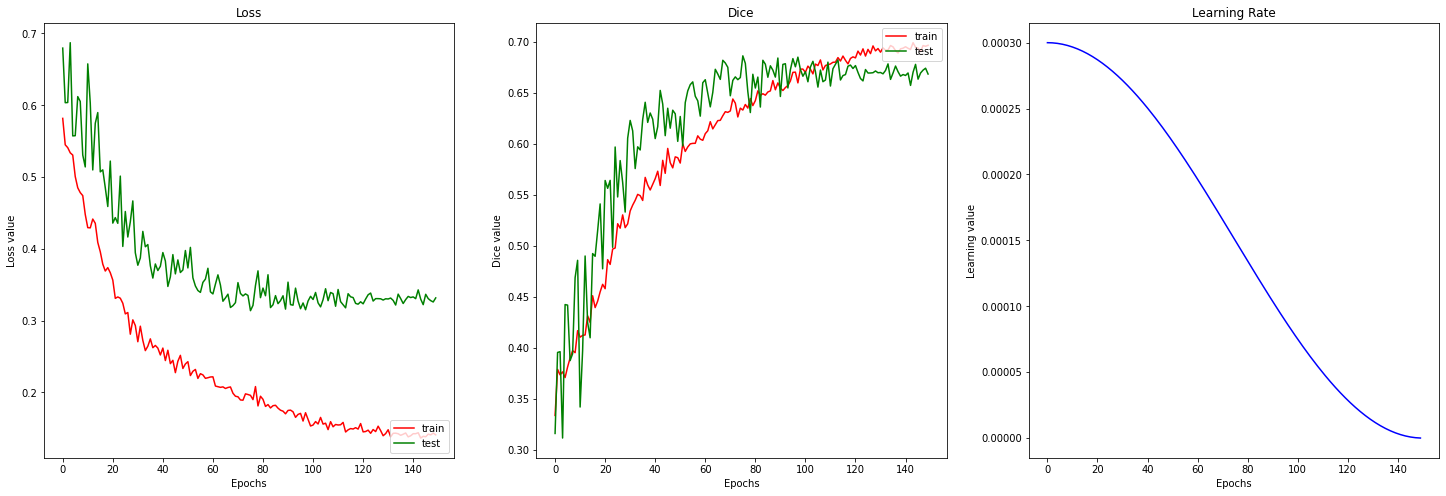

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
#plt.rcParams["figure.autolayout"] = True

# losses
axes[0].set_title('Loss')
axes[0].set(xlabel='Epochs')
axes[0].set(ylabel='Loss value')

axes[0].plot(history['epochs'], history['train_loss'], 'r', label='train')
axes[0].legend(loc='upper right')
axes[0].plot(history['epochs'], history['test_loss'], 'g', label='test')
axes[0].legend(loc='lower right')

# losses
axes[1].set_title('Dice')
axes[1].set(xlabel='Epochs')
axes[1].set(ylabel='Dice value')
axes[1].plot(history['epochs'], history['train_dice'], 'r', label='train')
axes[1].legend(loc='lower right')
axes[1].plot(history['epochs'], history['test_dice'], 'g', label='test')
axes[1].legend(loc='upper right')

# losses
axes[2].set_title('Learning Rate')
axes[2].set(xlabel='Epochs')
axes[2].set(ylabel='Learning value')
axes[2].plot(history['epochs'], history['lr'], 'b')

plt.plot()

In [31]:
from PIL import Image

def mask_to_rle(mask, orig_dim=160):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [32]:
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader

class DatasetTest(BaseDataset):
    def __init__(
        self,
        df: pd.DataFrame, img_path: Path,
        transform: callable = None, return_class: bool = False
    ):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.return_class = return_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        im = self.img_path+ "/"+ f"{self.df['id'].iloc[idx]}.tiff"
        
        img = cv2.imread(str(im))
#         print(list(img.shape))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         print(list(img.shape))
#         img=img.rescale(2048,2048)
        img = cv2.resize(img, (2048,2048))
        img = np.array(img).astype(np.float32)
        
        if self.transform:
            augment = self.transform(image=img)
            img = augment['image']
            
        if self.return_class:
            return img, self.df['organ'].iloc[idx]
        return img

In [33]:
import torch
from skimage import color
torch.cuda.empty_cache()

In [34]:
def show_masked_img(img, mask, title=''):
    #rescalse mask to 0-1 range regardless of min and max value
    mask = (mask - mask.min())/(mask.max()-mask.min())
    mask = torch.nan_to_num(mask) #Adress NaN incase of zerodiv error
    #Round up the mask
    mask = torch.round(mask)
    mask = mask.reshape(img.shape[1:3])
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)

 
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(title, fontsize=16)
    img, mask = img.numpy(), mask.numpy()
    
    ax[0].imshow(mask); ax[0].set_title('Mask')
    ax[1].imshow(img); ax[1].set_title('Image')
    ax[2].imshow(img); ax[2].imshow(mask*255, alpha=0.4); ax[2].set_title('Overlay')
    plt.show()

In [35]:
test_df = pd.read_csv("/kaggle/input/hubmap-organ-segmentation/test.csv")
test_path= "/kaggle/input/hubmap-organ-segmentation/test_images/"
#test_df['organ'] = test_df.organ.apply(lambda x: organ_mapper.get(x, 5))
test_data = DatasetTest(test_df,img_path=test_path, transform = albu.Compose([
        albu.PadIfNeeded(
            min_height=None,
            min_width=None,
            pad_height_divisor=32,
            pad_width_divisor=32,
        ),
        albu.Normalize(),
        ToTensorV2(transpose_mask=True)
    ]))
BATCH_SIZE = 1
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                          drop_last=False, num_workers=0)

model1=torch.load("model_final.pth", map_location=device)
model1.eval()
image_count = 0;
sub = {'id':[], 'rle':[]}

for x in test_loader:
    x = x.to(device)
    preds = model1(x)

    sub['id'].append(test_df.id[image_count])
    sub['rle'].append(mask_to_rle(np.array(preds.cpu().detach()), test_df.img_height.values[image_count]))
        
#    del preds
#    gc.collect()
    
    image_count += 1
    
#     if (image_count == 3):
#         break

sub = pd.DataFrame(sub)
sub.head()
sub.to_csv('submission.csv', index=False)
sub


i=0
for x in tqdm(test_loader):
    
    x=x.to(device)
    show_masked_img(x.cpu()[0],torch.Tensor(predictions[i]), title='Prediction Sample')
    i+=1


  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'predictions' is not defined